## Machine Learning for Credit Card Payment Classification

## Introduction
This work aims to apply some ensemble techniques and carry out a comparative study in order to classify customers in relation to credit card payments. The data used here were obtained from kaggle and are provided by the UCI, originally presenting 30000 observations of 24 variables.

The models that will be fitted and compared are:
- Decision Tree;
- Random Forest;
- AdaBossting;
- Gradient Boosting.

For parameters selection, we applied the cross-validation procedure and after choosing the best value of the parameters, the performance of each model was evaluated by means of the metrics of accuracy, precision and recall for the test and training cases.

In [1]:
import plotly.offline as pyo
import plotly.graph_objs as go
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import matplotlib as mpl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from keras import datasets
from keras import layers
from keras import optimizers
from keras import models

import tensorflow as tf

def printmd(s):
    display(Markdown(s))

Reading data using pandas.

In [2]:
# Loading data
data = pd.read_csv('./UCI_Credit_Card.csv', index_col=0)
data = data.reset_index(drop=True)

Originally, the data presented categorical and numerical variables. The code below extracts the columns corresponding to each type of variable. The categorical variables are defined as integers.

In [3]:
# creating lists based on types of variables
df = data
numcols = df.dtypes[df.dtypes == 'float64'].index
Nnumcols = df.dtypes[df.dtypes != 'float64'].index

For numerical variables, data were normalized with aiming to reduce the computational cost without losing the order of magnitude of the values of each variable.

In [4]:
def normalization(x):
    return (x-x.mean())/x.std()

ndf = normalization(df[numcols.tolist() + ['AGE']])

For each categorical variable, the one-hot encoding technique is applied, which consists of transforming the $n$ classes of categorical variables into $n$ binary variables.

In [5]:
# Dropping non categorical columns - and y column
cats = data[Nnumcols].drop(['AGE', 'default.payment.next.month'], axis=1).columns

# One-hot encoding categorical variables
ohe = OneHotEncoder(sparse=False)
ohe_df = ohe.fit_transform(df[cats])
ohe_df = pd.DataFrame(ohe_df, columns=ohe.get_feature_names_out())

# Joining formatted data
data = pd.concat([df[['default.payment.next.month']], ohe_df, ndf], axis=1)

We separate the variable of interest (y) from the covariates (X).

In [6]:
# X and y spllited
X = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']

Calculating the percentage of each of the response variable classes, where 1 is equivalent to the 'Default' class and 0 to 'Paid', it can be seen that we are dealing with a problem of unbalanced data. For this reason, all models were adjusted with weights inversely proportional to the probability of each class.

In [7]:
print(len(y[y==1])/len(y))
print(len(y[y==0])/len(y))

0.2212
0.7788


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# Generic function for Cross-Validation
def generate_model(classifier, X, y, params, n_splits):
  cv = KFold(n_splits=n_splits, random_state=1, shuffle=True)
  acc_test_mean = []
  acc_train_mean = []
  prec_test_mean = []
  prec_train_mean = []
  rec_test_mean = []
  rec_train_mean = []
  for par in params:
    acc_test = []
    acc_train = []
    prec_train = []
    prec_test = []
    rec_train = []
    rec_test = []
    for train_index, test_index in cv.split(X):
      # train test split
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y[train_index], y[test_index]

      if classifier == 'RF':
        model = RandomForestClassifier(n_estimators=par, max_depth=3, class_weight='balanced',
                                       random_state=0)
      elif classifier == 'Gboost':
        model = GradientBoostingClassifier(n_estimators=par, random_state=0)
      elif classifier == 'DT':
        model = DecisionTreeClassifier(max_depth=par, class_weight='balanced')
      elif classifier == 'adaboost':
        model = AdaBoostClassifier(n_estimators=par)

      # model training
      model.fit(X_train, y_train)

      # predictions
      y_pred_test = model.predict(X_test)
      y_pred_train = model.predict(X_train)

      # accuracy, precision and recall
      acc_test.append(metrics.accuracy_score(y_test, y_pred_test))
      acc_train.append(metrics.accuracy_score(y_train, y_pred_train))

      prec_train.append(metrics.precision_score(y_train, y_pred_train))
      prec_test.append(metrics.precision_score(y_test, y_pred_test))

      rec_train.append(metrics.recall_score(y_train, y_pred_train))
      rec_test.append(metrics.recall_score(y_test, y_pred_test))

    # average evaluation metrics
    acc_test_mean.append(np.array(acc_test).mean())
    acc_train_mean.append(np.array(acc_train).mean())

    prec_test_mean.append(np.array(prec_test).mean())
    prec_train_mean.append(np.array(prec_train).mean())

    rec_test_mean.append(np.array(rec_test).mean())
    rec_train_mean.append(np.array(rec_train).mean())


  return acc_train_mean, acc_test_mean, prec_train_mean, prec_test_mean, rec_train_mean, rec_test_mean

We split the data into training and test sets so that we could evaluate the model on a data set that was not presented to the model during training. Thus, we can measure the generalization power of the model.

In [9]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X, y, test_size=0.4)

## Decision Tree

The first method to be tested is decision tree, where the variable parameter was the maximum depth of the tree. In this work, I will not go into details about the operation and/or the theory behind the methods.

Cross-validation is performed for decision trees and the behavior graph of training and test accuracy is used to choose the best parameter.

In [10]:
# Decision Tree Cross Validation
params = [2, 3, 4, 5, 6, 8, 10]
acc_train_mean, acc_test_mean, prec_train_mean, prec_test_mean, rec_train_mean, rec_test_mean = generate_model(classifier='DT', X=X, y=y, params=params, n_splits=5)

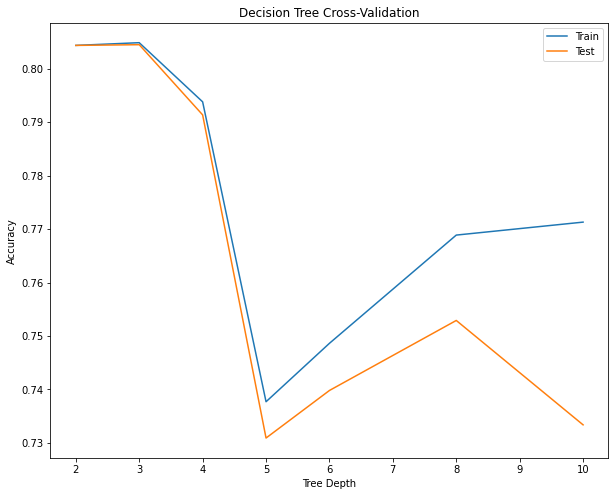

In [11]:
# evaluation metrics dataframe creation
acc_mean_test = pd.DataFrame(acc_test_mean, index=params, columns=['acc_mean_test'])
acc_mean_train = pd.DataFrame(acc_train_mean, index=params, columns=['acc_mean_train'])
prec_mean_test = pd.DataFrame(prec_test_mean, index=params, columns=['prec_mean_test'])
prec_mean_train = pd.DataFrame(prec_train_mean, index=params, columns=['prec_mean_train'])
rec_mean_test = pd.DataFrame(rec_test_mean, index=params, columns=['rec_mean_test'])
rec_mean_train = pd.DataFrame(rec_train_mean, index=params, columns=['rec_mean_train'])


results = pd.DataFrame(pd.concat([acc_mean_train, acc_mean_test,
                                  prec_mean_train, prec_mean_test,
                                  rec_mean_train, rec_mean_test,], axis=1))

# CV results plot
plt.figure(figsize=(10,8))
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Cross-Validation')
plt.plot(results['acc_mean_train'], label='Train')
plt.plot(results['acc_mean_test'], label='Test')
plt.legend()
plt.show()

As we can see, the best values for the accuracy is found when using 2 or 3 as the DT model parameter. Since we want our model to be as complex as it can be without losing accuracy, we select 3 as the oficial parameter.

In [12]:
for i in params:
    print("RESULTS FOR TREE DEPTH {0}".format(i))
    print(results.loc[i])
    print("\n")

RESULTS FOR TREE DEPTH 2
acc_mean_train     0.804367
acc_mean_test      0.804367
prec_mean_train    0.576663
prec_mean_test     0.576788
rec_mean_train     0.434759
rec_mean_test      0.434897
Name: 2, dtype: float64


RESULTS FOR TREE DEPTH 3
acc_mean_train     0.804875
acc_mean_test      0.804500
prec_mean_train    0.578537
prec_mean_test     0.577636
rec_mean_train     0.434272
rec_mean_test      0.433069
Name: 3, dtype: float64


RESULTS FOR TREE DEPTH 4
acc_mean_train     0.793808
acc_mean_test      0.791367
prec_mean_train    0.536936
prec_mean_test     0.530946
rec_mean_train     0.494816
rec_mean_test      0.490281
Name: 4, dtype: float64


RESULTS FOR TREE DEPTH 5
acc_mean_train     0.737692
acc_mean_test      0.730900
prec_mean_train    0.436652
prec_mean_test     0.426660
rec_mean_train     0.633068
rec_mean_test      0.622168
Name: 5, dtype: float64


RESULTS FOR TREE DEPTH 6
acc_mean_train     0.748625
acc_mean_test      0.739800
prec_mean_train    0.453423
prec_mean_test 

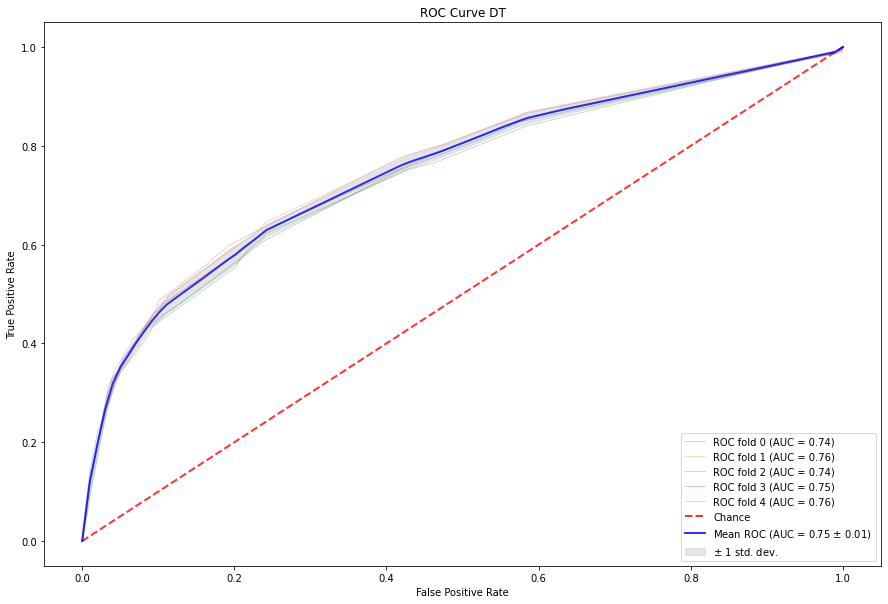

In [13]:
# Average ROC curve plot
from scipy import interp
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=True)
classifier = DecisionTreeClassifier(max_depth=6)
model = classifier

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X)):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DT')
plt.legend(loc="lower right")
plt.show()

With the graph of the ROC curve we can see that, on average, our decision tree is able to separate a large percentage of the data relatively well. However, when analyzing the confusion matrix below, it is noted that the accuracy is high, but unbalanced.

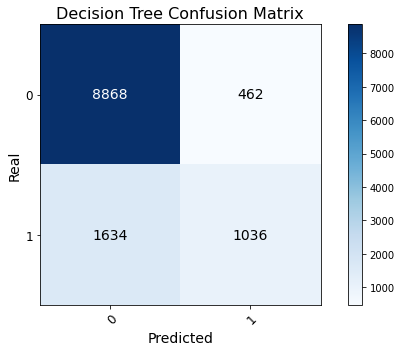

In [14]:
# Decision Tree Confusion Matrix
y_pred = model.predict(X_TEST)

# Labels
y_true = Y_TEST

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(0, 2))
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=(0, 1),
       yticks=(0, 1),
       xticklabels=classes, yticklabels=classes)

ax.set_title("Decision Tree Confusion Matrix", fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size= 12)

plt.setp(ax.get_yticklabels(), size= 12)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center", fontsize=14,
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

Therefore, we conclude for this model that even applying the weights to the classes, the method still has difficulty in correctly classifying cases of the minority class ("Default"). This means that our model is bad at figuring out who won't pay the credit card bill the following month, but it's good at figuring out who will pay.

## Random Forest

The same methodology applied to the decision tree was applied to the next methods. Therefore, the interpretation part of each step will not be explored in a peculiar way.

In [15]:
# Random Forest Cross Validation
params = list(range(5, 50, 5))
acc_train_mean, acc_test_mean, prec_train_mean, prec_test_mean, rec_train_mean, rec_test_mean = generate_model(classifier='RF', X=X, y=y.values.ravel(), params=params, n_splits=5)

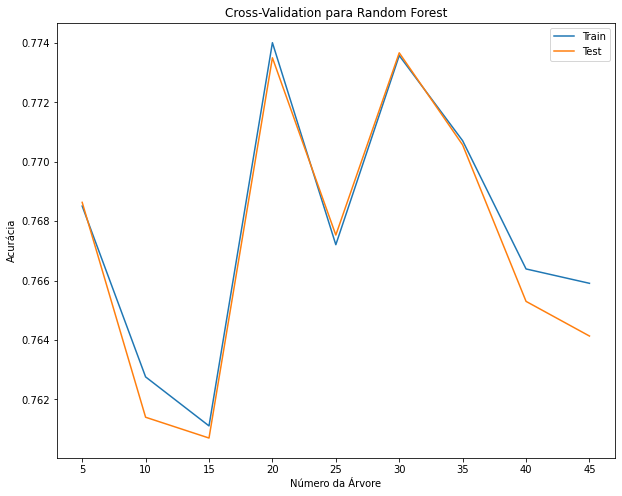

In [16]:
# Dataframes results
acc_mean_test = pd.DataFrame(acc_test_mean, index=params, columns=['acc_mean_test'])
acc_mean_train = pd.DataFrame(acc_train_mean, index=params, columns=['acc_mean_train'])
prec_mean_test = pd.DataFrame(prec_test_mean, index=params, columns=['prec_mean_test'])
prec_mean_train = pd.DataFrame(prec_train_mean, index=params, columns=['prec_mean_train'])
rec_mean_test = pd.DataFrame(rec_test_mean, index=params, columns=['rec_mean_test'])
rec_mean_train = pd.DataFrame(rec_train_mean, index=params, columns=['rec_mean_train'])


results = pd.DataFrame(pd.concat([acc_mean_train, acc_mean_test,
                                  prec_mean_train, prec_mean_test,
                                  rec_mean_train, rec_mean_test,], axis=1))

# Visualization
plt.figure(figsize=(10,8))
plt.xlabel('Número da Árvore')
plt.ylabel('Acurácia')
plt.title('Cross-Validation para Random Forest')
plt.plot(results['acc_mean_train'], label='Train')
plt.plot(results['acc_mean_test'], label='Test')
plt.legend()
plt.show()

In [17]:
for i in params:
    print("RESULTS FOR RANDOM FOREST NUMBER OF ESTIMATORS {0}".format(i))
    print(results.loc[i])
    print("\n")

RESULTS FOR RANDOM FOREST NUMBER OF ESTIMATORS 5
acc_mean_train     0.768508
acc_mean_test      0.768633
prec_mean_train    0.480883
prec_mean_test     0.481310
rec_mean_train     0.577740
rec_mean_test      0.579422
Name: 5, dtype: float64


RESULTS FOR RANDOM FOREST NUMBER OF ESTIMATORS 10
acc_mean_train     0.762758
acc_mean_test      0.761400
prec_mean_train    0.473421
prec_mean_test     0.471302
rec_mean_train     0.595031
rec_mean_test      0.593126
Name: 10, dtype: float64


RESULTS FOR RANDOM FOREST NUMBER OF ESTIMATORS 15
acc_mean_train     0.761108
acc_mean_test      0.760700
prec_mean_train    0.470276
prec_mean_test     0.469932
rec_mean_train     0.599148
rec_mean_test      0.595439
Name: 15, dtype: float64


RESULTS FOR RANDOM FOREST NUMBER OF ESTIMATORS 20
acc_mean_train     0.774008
acc_mean_test      0.773500
prec_mean_train    0.491937
prec_mean_test     0.491361
rec_mean_train     0.588261
rec_mean_test      0.583167
Name: 20, dtype: float64


RESULTS FOR RANDOM FOR

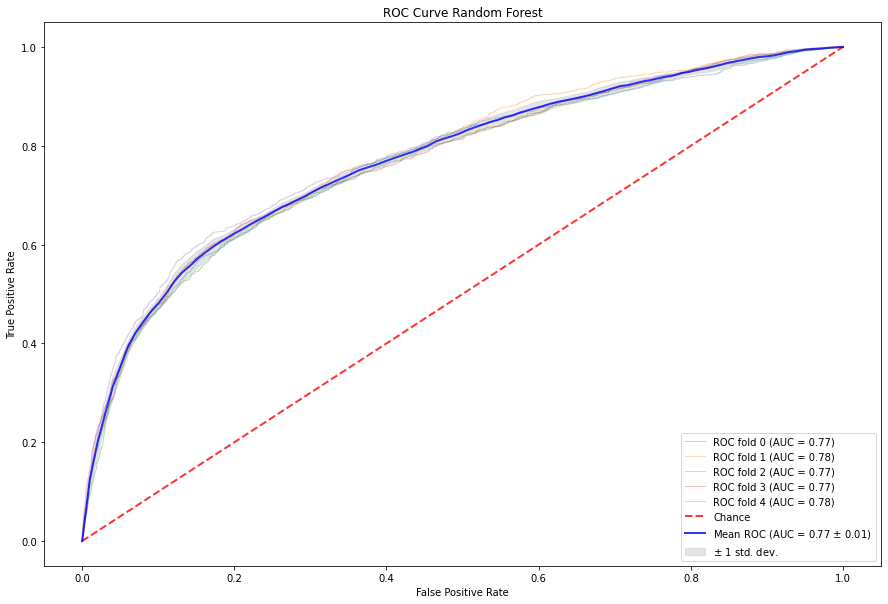

In [18]:
# Curva ROC média para RF
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=True)
classifier = RandomForestClassifier(n_estimators=40, max_depth=6)
model = classifier

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X)):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Random Forest')
plt.legend(loc="lower right")
plt.show()

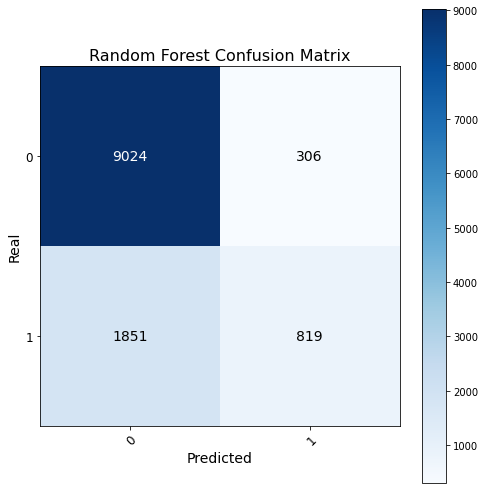

In [19]:
# Predictions
y_pred = model.predict(X_TEST)

# Labels
y_true = Y_TEST

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(0, 2))
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=(0, 1),
       yticks=(0, 1),
       xticklabels=classes, yticklabels=classes)

ax.set_title("Random Forest Confusion Matrix", fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size= 12)

plt.setp(ax.get_yticklabels(), size= 12)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center", fontsize=14,
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

We can observe that the accuracy for Random Forests was slightly lower to that found with only one decision tree. However, the confusion matrix reveals that the imbalance problem becomes more evident. Our model manages to be superior for targeting customers who will pay the card, but inferior for the opposite cases.
As customers who do not pay bills are responsible for financial institutions' losses, our model may be considered bad by some of these institutions.

## AdaBoost

For the AdaBoost method, weights were not used as in the others. This is because this method assigns weights to wrong classifications at each iteration. As we have seen that the method to be ensembled (decision trees) has difficulty classifying minority classes, it is expected that AdaBoost will naturally assign greater weights to this class.

In [20]:
# AdaBoosting Cross Validation
params = list(range(2, 15, 1))
acc_train_mean, acc_test_mean, prec_train_mean, prec_test_mean, rec_train_mean, rec_test_mean = generate_model(classifier='adaboost', X=X, y=y.values.ravel(), params=params, n_splits=5)

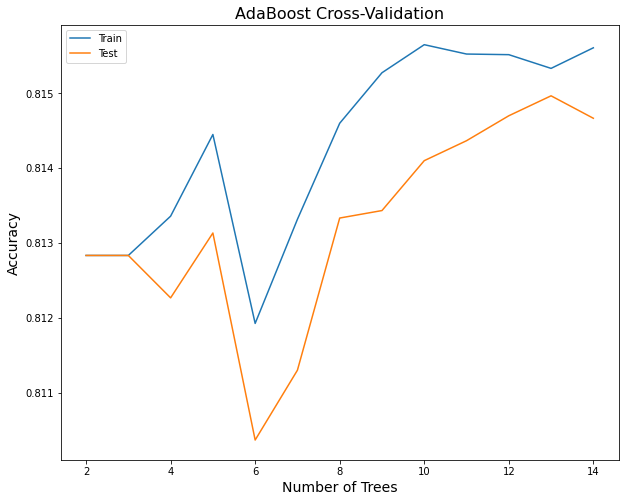

In [21]:
# Results DataFrame
acc_mean_test = pd.DataFrame(acc_test_mean, index=params, columns=['acc_mean_test'])
acc_mean_train = pd.DataFrame(acc_train_mean, index=params, columns=['acc_mean_train'])
prec_mean_test = pd.DataFrame(prec_test_mean, index=params, columns=['prec_mean_test'])
prec_mean_train = pd.DataFrame(prec_train_mean, index=params, columns=['prec_mean_train'])
rec_mean_test = pd.DataFrame(rec_test_mean, index=params, columns=['rec_mean_test'])
rec_mean_train = pd.DataFrame(rec_train_mean, index=params, columns=['rec_mean_train'])

results = pd.DataFrame(pd.concat([acc_mean_train, acc_mean_test,
                                  prec_mean_train, prec_mean_test,
                                  rec_mean_train, rec_mean_test,], axis=1))

# Visual Results
plt.figure(figsize=(10,8))
plt.xlabel('Number of Trees', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('AdaBoost Cross-Validation', fontsize=16)
plt.plot(results['acc_mean_train'], label='Train')
plt.plot(results['acc_mean_test'], label='Test')
plt.legend()
plt.show()

In [22]:
for i in params:
    print("RESULTS FOR ADA BOOSTING NUMBER OF TREES {0}".format(i))
    print(results.loc[i])
    print("\n")

RESULTS FOR ADA BOOSTING NUMBER OF TREES 2
acc_mean_train     0.812833
acc_mean_test      0.812833
prec_mean_train    0.691436
prec_mean_test     0.691757
rec_mean_train     0.277887
rec_mean_test      0.278017
Name: 2, dtype: float64


RESULTS FOR ADA BOOSTING NUMBER OF TREES 3
acc_mean_train     0.812833
acc_mean_test      0.812833
prec_mean_train    0.691436
prec_mean_test     0.691757
rec_mean_train     0.277887
rec_mean_test      0.278017
Name: 3, dtype: float64


RESULTS FOR ADA BOOSTING NUMBER OF TREES 4
acc_mean_train     0.813358
acc_mean_test      0.812267
prec_mean_train    0.670537
prec_mean_test     0.666128
rec_mean_train     0.307909
rec_mean_test      0.306546
Name: 4, dtype: float64


RESULTS FOR ADA BOOSTING NUMBER OF TREES 5
acc_mean_train     0.814450
acc_mean_test      0.813133
prec_mean_train    0.674609
prec_mean_test     0.670568
rec_mean_train     0.313076
rec_mean_test      0.310305
Name: 5, dtype: float64


RESULTS FOR ADA BOOSTING NUMBER OF TREES 6
acc_mean_

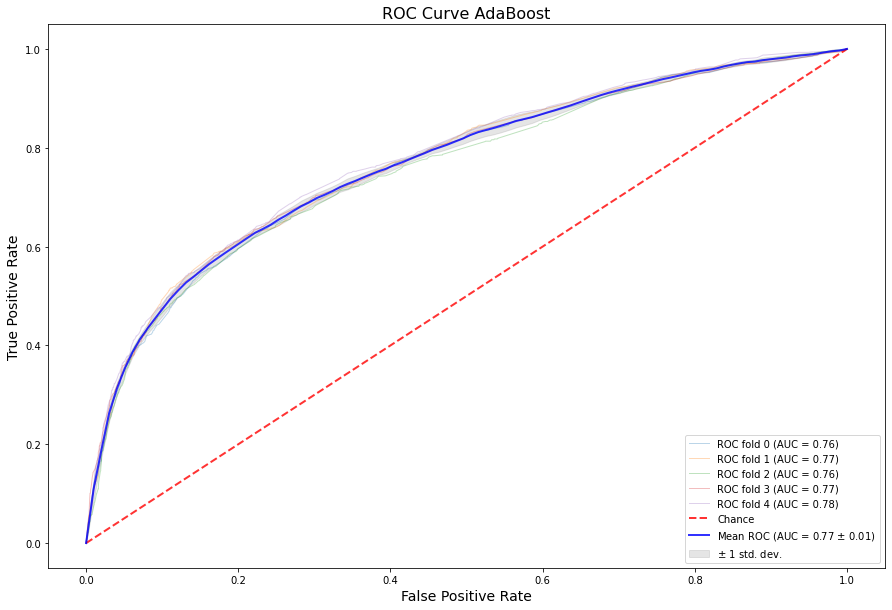

In [23]:
# Average ROC Curve for Adaboost
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=True)
classifier = AdaBoostClassifier(n_estimators=5, base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'))
model = classifier

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X)):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve AdaBoost', fontsize=16)
plt.legend(loc="lower right")
plt.show()

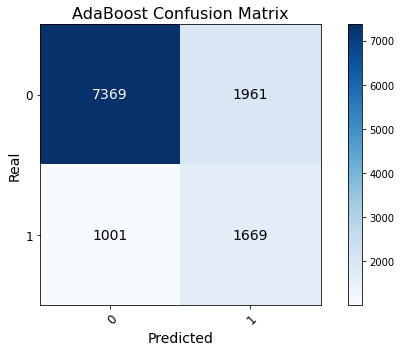

In [24]:
# Model predictions
y_pred = model.predict(X_TEST)

# Labels
y_true = Y_TEST

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(0, 2))
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=(0, 1),
       yticks=(0, 1),
       xticklabels=classes, yticklabels=classes)

ax.set_title("AdaBoost Confusion Matrix", fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size= 12)

plt.setp(ax.get_yticklabels(), size= 12)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center", fontsize=14,
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

Note that AdaBoost presents a significant improvement in accuracy relative to the minority class, as expected. However, getting more cases of that class right causes the model to miss more classifications for the other class.

Despite this trade-off, the overall accuracy of the model was slightly higher than the value found for the previous methods.

## Gradient Boosting

Parameters for Gradient Boosting Cross Validation procedure.

In [25]:
params = list(range(2, 15, 1))
acc_train_mean, acc_test_mean, prec_train_mean, prec_test_mean, rec_train_mean, rec_test_mean = generate_model(classifier='Gboost', X=X, y=y.values.ravel(), params=params, n_splits=5)

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phara\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\phara\anaconda3\lib\site-pa

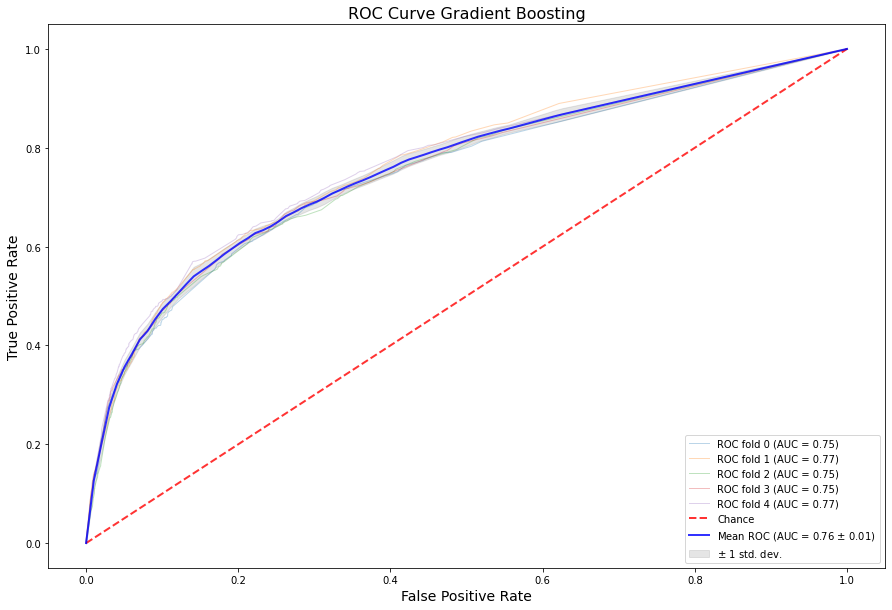

In [26]:
# Average ROC Curve
plt.figure(figsize=(15,10))
cv = KFold(n_splits=5, random_state=1, shuffle=True)
classifier = GradientBoostingClassifier(n_estimators=10)
model = classifier

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X)):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve Gradient Boosting', fontsize=16)
plt.legend(loc="lower right")
plt.show()

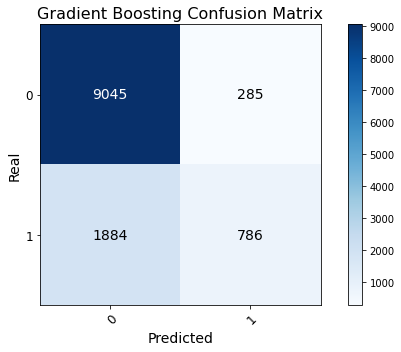

In [27]:
y_pred = model.predict(X_TEST)
y_true = Y_TEST

cm = metrics.confusion_matrix(y_true, y_pred)
classes = list(range(0, 2))
fig, ax = plt.subplots(figsize=(8, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=(0, 1),
       yticks=(0, 1),
       xticklabels=classes, yticklabels=classes)

ax.set_title("Gradient Boosting Confusion Matrix", fontsize=16)
ax.set_xlabel('Predicted', fontsize=14)
ax.set_ylabel('Real', fontsize=14)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor", size= 12)

plt.setp(ax.get_yticklabels(), size= 12)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center", fontsize=14,
                color="white" if cm[i, j] > cm.max()/2. else "black")
fig.tight_layout()
plt.show()

We conclude that the Gradient Tree Boosting method presented results similar to those found by the first 2 methods. Therefore, the analysis to be done here follows the same logical concept applied to such methods.

## Conclusion

At the end of this propject, it was possible to observe the behavior of some ensemble Machine Learning methods for a dataset with unbalanced classes.

After testing 4 different methods, the AdaBoost method showed the greatest ability to distinguish between classes, due to the natural attribution of weights to erroneously classified cases.

As a proposal for future work, there is the possibility of testing the behavior of this problem with other classifiers, such as SVM and KNN. Furthermore, it is possible to perform a comparison with the same classifiers for other techniques for unbalanced problems besides weighting.